## Geographic and Timeline Analysis
#### 1. Where are the twitterers located, identify relationships between new issues in education and locations.
#### 2. Visualize the geographical distribution of the tweets.
#### 3. What are the timelines of the tweets, identify the peaks, valleys and data collection gaps.
#### 4. Visualize the timelines of the tweets

In [1]:
import sys
import time
import pyspark
import os
import shutil
import subprocess
# import sh
import re

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import compress, islice 
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import SparkSession
from IPython.display import clear_output
clear_output(wait = False)

warnings.filterwarnings(action='ignore')

start_time = time.time()
#Ensure we are using the right kernel
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [11]:
# !pip uninstall -y nltk
# !pip install nltk --upgrade --no-cache-dir
# %pip install nltk -U
# !pip install geograpy3
# !pip install geopy
# !pip install geocoder
# !pip install plotly
# clear_output(wait = False)

In [12]:
#import geograpy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
# nltk.download('popular', halt_on_error=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tuning Spark to increase the memory

In [2]:
sc = spark.sparkContext
print('Original spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Stop existing Spark environment
sc.stop()

# Waiting for the environment to stop
sleep_time = 10
print(f'Waiting for {sleep_time} seconds for the enviroment to stop...')
time.sleep(sleep_time)

# Applying new configuration and restarting Spark
conf = pyspark.SparkConf().setAll([('spark.driver.maxResultSize', '8g')])
sc = pyspark.SparkContext(conf=conf)

print('New spark.driver.maxResultSize: ' + sc._conf.get('spark.driver.maxResultSize'))

# Starting  Spark session with configs applied
spark = SparkSession(sc).builder.getOrCreate()

Original spark.driver.maxResultSize: 1920m
Waiting for 10 seconds for the enviroment to stop...


23/03/08 22:51:36 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/03/08 22:51:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/03/08 22:51:36 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/03/08 22:51:36 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


New spark.driver.maxResultSize: 8g


In [3]:
# Display the spark DF in a beautified way
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

# To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
path = 'gs://msca-bdp-students-bucket/shared_data/saikrishnaj/final_eda/'
cmd = 'hadoop fs -du -s -h ' + path

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

4.5 G  4.5 G  gs://msca-bdp-students-bucket/shared_data/saikrishnaj/final_eda



In [5]:
%time df = spark.read.parquet(path)

CPU times: user 9.88 ms, sys: 2.05 ms, total: 11.9 ms
Wall time: 8.13 s


23/03/08 22:51:56 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [19]:
##Filtering the data with no nulls in location 
df_loc = df.filter("user_location is not null and followers_count is not null")\
           .select(['user_created_at','user_id','user_name','user_location', 'followers_count', 'tweet_id', 'tweet_text'])

In [20]:
df_loc.count()

2988297

In [10]:
df_loc.limit(10)

user_created_at,user_id,user_name,user_location,followers_count,tweet_id,tweet_text
2017-11-03 04:05:32,926299277588123649,Khoa Vu,"Minnesota, USA",37471,1549486335601152000,📢 Interested in ...
2021-05-14 16:13:50,1393237981981446149,Astrid #justicefo...,"Rotterdam, Nederland",785,1549486357151719432,@BIP45774476 yes ...
2012-04-20 13:06:35,558618962,HPC2atMSU,Mississippi State...,383,1549486368278990848,As the Mississipp...
2017-08-20 11:35:06,899233325365252096,Shahab,Pakistan,42,1549486432842031104,For an overwhelmi...
2009-05-06 22:19:36,38291999,Kay Ponder☮️,"North Carolina, USA",2430,1549486483341443072,Enrollment at pub...
2012-05-20 03:57:34,585341968,Tyrne Clark,Ontario 🇨🇦,66065,1549486509107150848,Many school distr...
2009-11-28 16:15:00,93211318,IG -- engr_olutiago,D Seven Seas..,356,1549486683560841219,🇨🇦CANADIAN SCHO...
2008-03-28 21:38:52,14247236,Scott Dworkin,"Washington, DC",1094370,1549486743359033345,"""From schools to ..."
2011-05-01 22:38:44,291382878,Ahmed Garmaqate,Garoe,2437,1549486743195422721,The Global Scienc...
2017-10-03 13:24:52,915206013049024512,Nicki,"Michigan, USA",1382,1549486753693696001,We awarded $6.5 m...


In [11]:
df_loc_pd = df_loc.groupby('user_location')\
      .agg(count('*').alias('num_tweets'))\
      .orderBy('num_tweets',ascending = False)#.toPandas()

In [12]:
df_loc_pd.limit(100).agg(sum('num_tweets'))

sum(num_tweets)
799146


In [13]:
df_loc_pd = df_loc_pd.limit(500).toPandas()

In [14]:
np.sum(df_loc_pd.num_tweets)

1274943

In [43]:
# https://simplemaps.com/data/us-cities
cities_us = spark.read.csv('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/uscities.csv', header= True)
cities_world = spark.read.csv('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/worldcities.csv', header = True)

In [16]:
# getting all cities in the world where population is greater than a 1000
# https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/export/?disjunctive.cou_name_en&sort=name
locs = spark.read.options(delimiter = ';').csv('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/geonames-all-cities-with-a-population-1000.csv', header= True)

In [17]:
locs = locs.select(['Name','Alternate Names','Country Code','Country name EN']).distinct()

In [18]:
locs.limit(10)

Name,Alternate Names,Country Code,Country name EN
Cherry Valley,null,US,United States
Okrika,Okrika,NG,Nigeria
Biratnagar,"BIR,Biratnagar,Bi...",NP,Nepal
Banawang,"Banawang,Bangwang",PH,Philippines
Baclayon,Baclayon,PH,Philippines
Mălini,"Malini,Mălini",RO,Romania
Caţa,"Cata,Caţa,Katzendorf",RO,Romania
Torda,"Jordan,Kistorda,T...",RS,Serbia
Manolo Fortich,"Maluko,Manolo For...",PH,Philippines
Heyuan,"Che-juean,Che-jüa...",CN,China


In [15]:
%%time
import geocoder
import pandas as pd
import time

# define a function to geocode locations in batches

def geocode_batch(locations):
    # geocode the locations in batches
    batch_size = 100
    results = []
    for i in range(0, len(locations), batch_size):
        batch = locations[i:i+batch_size]
        batch_str = ','.join([''] if x is None else x for x in batch)
        # geocode the batch
        g = geocoder.osm(batch_str, timeout=10)
        if g.ok:
            results.extend(g)
        # sleep to avoid hitting rate limits
        time.sleep(1)
    return results


# define a function to get country from location
def get_country(location, cache):
    # check if the country is in the cache
    if location in cache:
        return cache[location]
    
    # otherwise, geocode the location
    g = geocoder.osm(location, timeout=10)
    if g.ok:
        # cache the result
        cache[location] = g.country
        return g.country
    else:
        return None

# initialize a cache
cache = {}

# extract the locations from the Pandas DataFrame as a list
locations = df_loc_pd['user_location'].tolist()

# geocode the locations in batches
results = geocode_batch(locations)

# map the results to a dictionary
location_dict = {}
for result in results:
    if result is not None:
        location_dict[result['query']] = result['country']

# add a new 'country' column to the dataframe
df_loc_pd['country'] = df_loc_pd['user_location'].apply(lambda location: get_country(location, cache))

CPU times: user 7.32 s, sys: 382 ms, total: 7.7 s
Wall time: 4min 23s


In [16]:
np.sum(df_loc_pd.num_tweets)

1274943

In [17]:
df_loc_pd.iloc[10:30]

,user_location,num_tweets,country
10,"Los Angeles, CA",14000,United States
11,"London, England",13793,United Kingdom
12,"Chicago, IL",12854,United States
13,"Nairobi, Kenya",12601,Kenya
14,United Kingdom,11626,United Kingdom
15,Earth,11020,United States
16,"New Delhi, India",10740,India
17,"Houston, TX",10738,United States
18,London,10197,United Kingdom
19,"New York, USA",10187,United States


In [18]:
# create pyspark dataframe from pandas dataframe
df_loc_pd_spark = spark.createDataFrame(df_loc_pd.rename(columns={'user_location': 'user_location_pd'}))

# join dataframes on user_location and location columns
df_loc_joined = df_loc.join(broadcast(df_loc_pd_spark), df_loc.user_location == df_loc_pd_spark.user_location_pd, "left_outer")

# select required columns
df_loc_country = df_loc_joined.select("user_created_at", "user_id", "user_name", "user_location", "followers_count", "tweet_id", "tweet_text", "country")


In [19]:
df_loc_country.filter('country is not null').count()

1256263

In [20]:
df_loc_country = df_loc_country.filter('country is not null')
df_loc_country = df_loc_country.dropDuplicates(['user_id'])

In [21]:
df_loc_country.limit(10)

user_created_at,user_id,user_name,user_location,followers_count,tweet_id,tweet_text,country
2012-12-09 19:44:18,1000014716,Badger,Here,23,1590528746087682054,@LastSaneManLeft ...,Bosna i Hercegovi...
2018-05-25 14:47:16,1000025513812004864,Rajendra sharma,"New Delhi, India",618,1592036028462006272,"""BJP/RSS wants Hi...",India
2018-05-25 15:37:29,1000038151036067841,BettingRepublic ?...,Nigeria,48541,1594646094444924928,He'd miss classes...,Nigeria
2009-12-28 17:42:30,100004865,Charlie Stephenson,UK,213,1601323493433683968,@stowgood @zarahs...,United Kingdom
2018-05-25 17:48:40,1000071162116878336,𝖆𝖉𝖔𝖓𝖎𝖘,"Pretoria, South A...",223,1545121914963861510,Help me get the d...,South Africa
2009-12-28 17:53:13,100007154,Unemployed Brendan,"Dallas, TX",33,1597655992178970624,Public schools bi...,United States
2006-10-21 17:55:17,10001,infogdss29,New England,1375,1529079341409308676,“71% of voters op...,United States
2018-05-25 19:48:04,1000101211301916674,Trenton Hedgepeth,"Florida, USA",114,1525273919653040128,I’m excited to an...,United States
2018-05-25 19:57:33,1000103597378453504,Gerard Sine,"Scottsdale, AZ",770,1523123115236085761,Going to college ...,United States
2012-12-09 20:31:58,1000109894,Jay Stephens™ 🎙,"Indianapolis, IN",1213,1546561558519717888,@coach_isaacs Yea...,United States


In [22]:
country_count = df_loc_country.groupBy(['country']).agg(count('user_id').alias('count_users'))\
                              .orderBy('count_users', ascending = False)

In [23]:
country_dist_pd = country_count.toPandas()

In [24]:
np.sum(country_dist_pd.count_users)

515591

In [25]:
country_dist_pd.head(10)

,country,count_users
0,United States,276455
1,United Kingdom,45057
2,Nigeria,44746
3,India,42875
4,Canada,24575
5,South Africa,11096
6,Kenya,10470
7,Australia,9864
8,پاکستان,9130
9,Ghana,6457


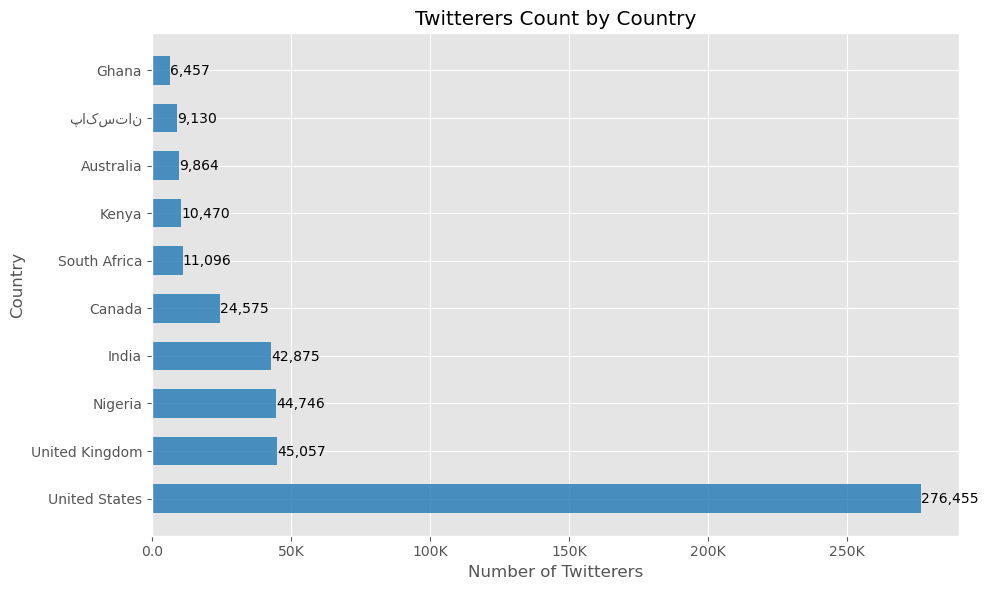

In [26]:
## Distribution of Tweets by Countries

import matplotlib.ticker as ticker

# set the plot style
plt.style.use('ggplot')
country_df = country_dist_pd.head(10)

# create a horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(country_df['country'], country_df['count_users'], color='tab:blue', alpha=0.8, height=0.6)
ax.set_xlabel('Number of Twitterers')
ax.set_ylabel('Country')
ax.set_title('Twitterers Count by Country')

# format the x-tick labels with a custom function
def format_tick(x, pos):
    if x >= 1_000_000:
        return f'{int(x/1_000_000)}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    else:
        return x

ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_tick))

# add the values to the bars
for i, v in enumerate(country_df['count_users']):
    ax.text(v + 3, i - 0.1, str("{:,}".format(v)), color='black', fontsize=10)

# display the plot
plt.tight_layout()
plt.show()


In [27]:
country_dist_pd.to_csv('gs://msca-bdp-students-bucket/shared_data/saikrishnaj/country_agg.csv')

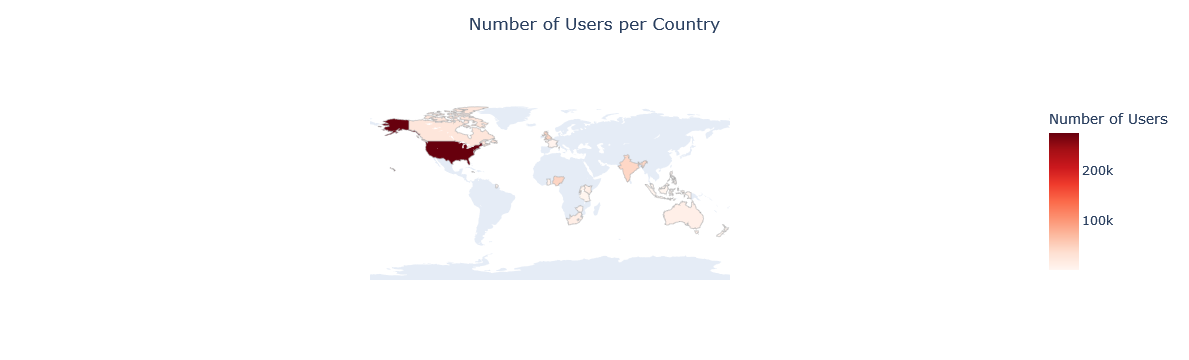

In [29]:
import plotly.express as px
import plotly.graph_objs as go
import pandas as pd

# Create a choropleth map
fig = go.Figure(go.Choropleth(
    locations = country_dist_pd['country'],
    locationmode = 'country names',
    z = country_dist_pd['count_users'],
    text = country_dist_pd['count_users'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Number of Users',
))

# Customize layout
fig.update_layout(
    title_text='Number of Users per Country',
    title_x=0.5, # Set the x position of the title to the middle
    title_y=0.95, # Set the y position of the title to the top of the plot
    geo=dict(
        scope='world', # set the scope to 'world'
        showframe=False,
        showcoastlines=False,
        projection_type='equirectangular'
    )
)

fig.show()

#### Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?

In [30]:
##Take top 5 countries and drill down based on month or day of the week to check for patterns first. 

In [31]:
countries = list(country_dist_pd.country[0:5])

# Filter the dataframe to only include tweets from the desired countries
tweets_by_country = df_loc_country.filter(df_loc_country.country.isin(countries))

# Add columns for year, month, and day of week
tweets_by_country = tweets_by_country.withColumn('year', year('user_created_at'))\
                                     .withColumn('month', month('user_created_at'))\
                                     .withColumn('dayofweek', dayofweek('user_created_at'))

In [40]:
tweets_by_country.limit(5)

user_created_at,user_id,user_name,user_location,followers_count,tweet_id,tweet_text,country,year,month,dayofweek
2018-05-25 14:47:16,1000025513812004864,Rajendra sharma,"New Delhi, India",618,1592036028462006272,"""BJP/RSS wants Hi...",India,2018,5,6
2018-05-25 15:37:29,1000038151036067841,BettingRepublic ?...,Nigeria,48541,1594646094444924928,He'd miss classes...,Nigeria,2018,5,6
2009-12-28 17:42:30,100004865,Charlie Stephenson,UK,213,1601323493433683968,@stowgood @zarahs...,United Kingdom,2009,12,2
2009-12-28 17:53:13,100007154,Unemployed Brendan,"Dallas, TX",33,1597655992178970624,Public schools bi...,United States,2009,12,2
2006-10-21 17:55:17,10001,infogdss29,New England,1375,1529079341409308676,“71% of voters op...,United States,2006,10,7


In [42]:
# Group by year and month to get monthly tweet counts
monthly_tweets = tweets_by_country.select(['user_id','tweet_id','country','year','month']).groupBy('year', 'month', 'country').agg(count('tweet_id').alias('count'))

# Group by day of week to get daily tweet counts
daily_tweets = tweets_by_country.groupBy('dayofweek', 'country').agg(count('tweet_id').alias('count'))

# Group by date to get overall tweet counts over time
overall_tweets = tweets_by_country.groupBy(date_format('user_created_at', 'yyyy-MM-dd').alias('date'), 'country').agg(count('tweet_id').alias('count'))

#### Plot the monthly distribution of the tweets in the top countries with twitter users

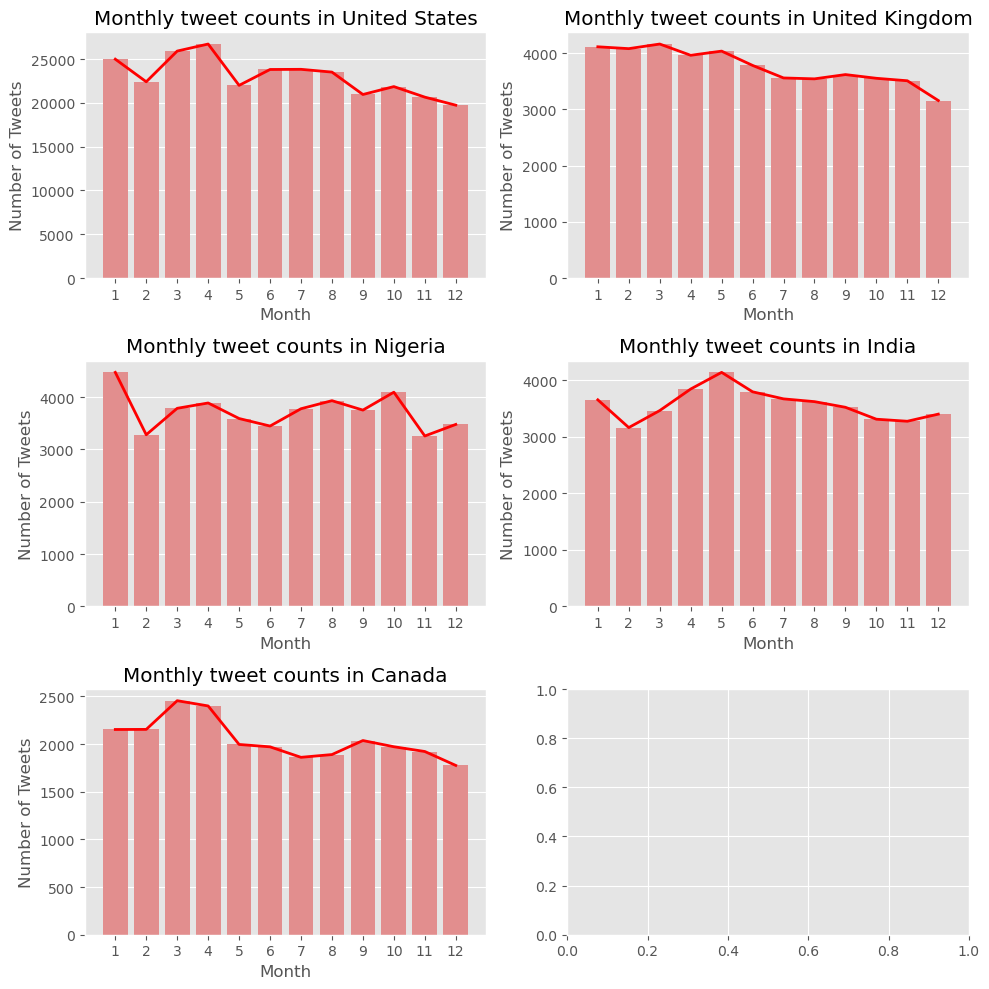

In [56]:
plt.style.use('ggplot')

# Define color palette for the barplots
colors = '#f08080'
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Add an offset to the lineplot to align it with the bars
offset = -1

for i, country in enumerate(countries):
    if i < 5:
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        country_df = monthly_tweets.filter(monthly_tweets.country == country)\
                                   .groupby('month').agg(sum('count').alias('count_tweets')).toPandas().sort_values(by='month')

        # Create a copy of 'month' column with an offset added to it
        x_of = country_df['month'] + offset

        sns.barplot(data=country_df, x='month', y='count_tweets', ax=ax, color=colors)
        sns.lineplot(data=country_df, x=x_of, y='count_tweets', ax=ax, color='red', lw=2)

        ax.set_title(f'Monthly tweet counts in {country}')
        ax.set_xlabel('Month')
        ax.set_ylabel('Number of Tweets')

    else:
        fig.delaxes(axs[2, 1])  # remove the last subplot
        axs = axs[:-1]     
plt.tight_layout()
plt.show()

#### Plot the Year wise distribution of the tweets in the top countries with twitter users

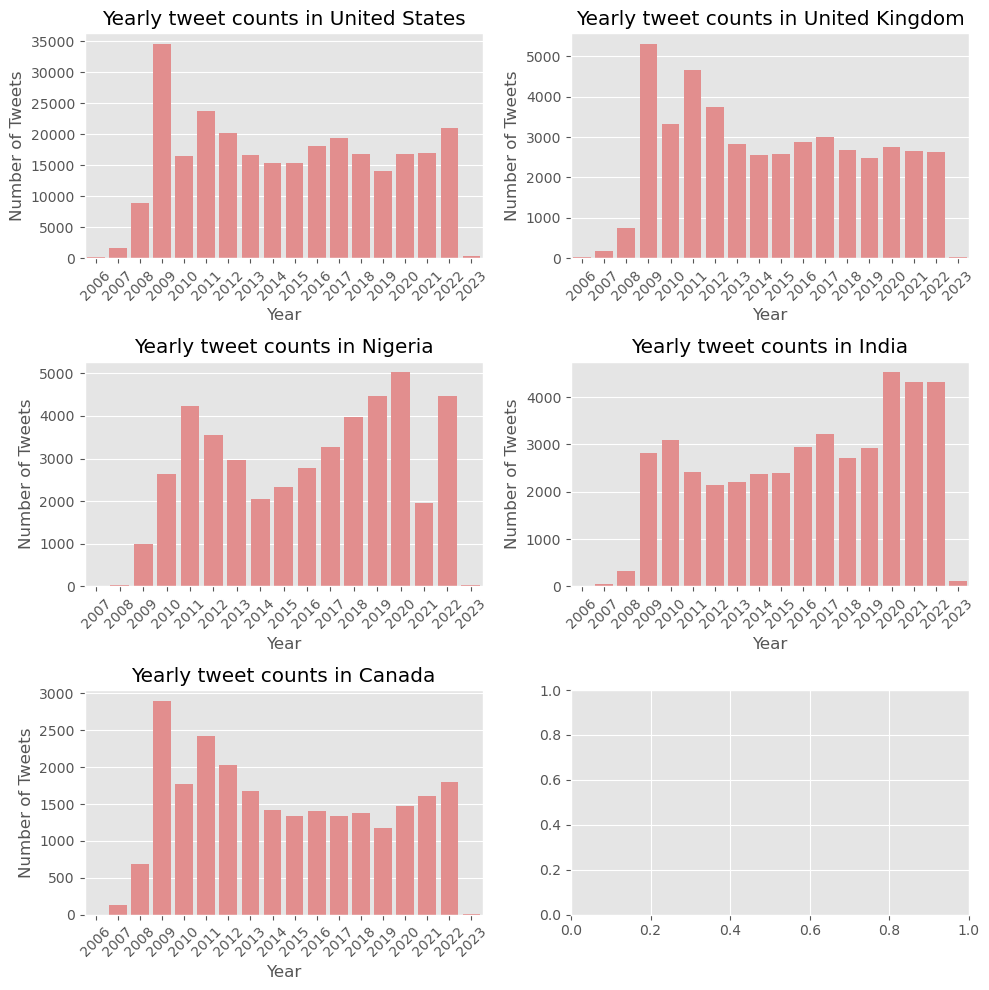

In [61]:
plt.style.use('ggplot')

# Define color palette for the barplots
colors = '#f08080'
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

# Add an offset to the lineplot to align it with the bars
# offset = -1

for i, country in enumerate(countries):
    if i < 5:
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        country_df = monthly_tweets.filter(monthly_tweets.country == country)\
                                   .groupby('year').agg(sum('count').alias('count_tweets')).toPandas().sort_values(by='year')

        # Create a copy of 'month' column with an offset added to it
        #x_of = country_df['year'] + offset

        sns.barplot(data=country_df, x='year', y='count_tweets', ax=ax, color=colors)
        #sns.lineplot(data=country_df, x='year', y='count_tweets', ax=ax, color='red', lw=2)

        ax.set_title(f'Yearly tweet counts in {country}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Tweets')
        ax.set_xticklabels(country_df['year'], rotation=45)  # rotate x-axis tick labels

    else:
        fig.delaxes(axs[2, 1])  # remove the last subplot
        axs = axs[:-1]     
plt.tight_layout()
plt.show()

### What are the timelines of the tweets, identify the peaks, valleys and data collection gaps.

In [22]:
df_timelines = df.select(['tweet_id','tweet_created_at'])\
                 .withColumn('tweet_created_at', to_date('tweet_created_at'))\
                 .groupby('tweet_created_at')\
                 .agg(count('tweet_id').alias('count_tweets'))

In [26]:
df_timelines_pd = df_timelines.toPandas()

In [29]:
df_timelines_pd.shape

(310, 2)

In [30]:
df_timelines_pd.dtypes

tweet_created_at    object
count_tweets         int64
dtype: object

In [34]:
df_timelines_pd['tweet_created_at'] = pd.to_datetime(df_timelines_pd['tweet_created_at'])
df_timelines_pd['year'] = df_timelines_pd['tweet_created_at'].dt.year
df_timelines_pd['month'] = df_timelines_pd['tweet_created_at'].dt.to_period('M')
df_timelines_pd['day'] = df_timelines_pd['tweet_created_at'].dt.day_name()
df_timelines_pd['dayNum'] = df_timelines_pd['tweet_created_at'].dt.dayofweek

In [35]:
df_timelines_pd.head()

,tweet_created_at,count_tweets,year,month,day,dayNum
0,2022-07-31,9524,2022,2022-07,Sunday,6
1,2022-07-27,17818,2022,2022-07,Wednesday,2
2,2022-08-02,16131,2022,2022-08,Tuesday,1
3,2022-11-29,16152,2022,2022-11,Tuesday,1
4,2022-05-19,16747,2022,2022-05,Thursday,3


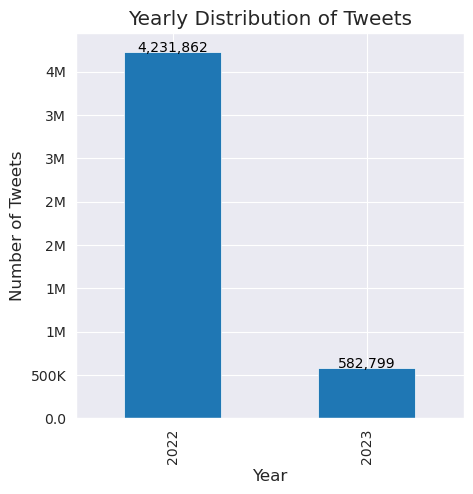

In [119]:
# Year wise distribution of plots
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(5, 5))

df_year = df_timelines_pd.groupby(by = 'year').sum('count_tweets')
yearplot = df_year['count_tweets'].plot(kind = 'bar', color= 'tab:blue')

ax.set_ylabel('Number of Tweets')
ax.set_xlabel('Year')
ax.set_title('Yearly Distribution of Tweets')

# format the y-tick labels with a custom function
def format_tick(x, pos):
    if x >= 1_000_000:
        return f'{int(x/1_000_000)}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    else:
        return x

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_tick))

# add the values to the bars
for i, v in enumerate(df_year['count_tweets']):
    ax.text(i, v + 3, str("{:,}".format(v)), ha='center', color='black', fontsize=10)

plt.show()

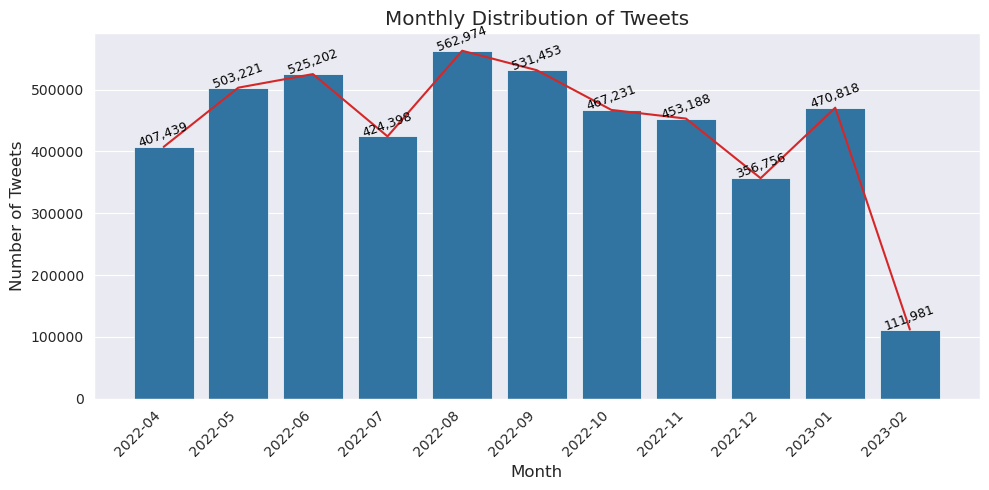

In [115]:
# Monthly distribution of tweets
import matplotlib.pyplot as plt
import seaborn as sns

# set the plot style
sns.set_style('darkgrid')

# convert month column to string format
df_month = df_timelines_pd.groupby(by='month').sum()
df_month.reset_index(inplace=True)
df_month['month'] = df_month['month'].dt.strftime('%Y-%m')

# create bar plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=df_month, x='month', y='count_tweets', color='tab:blue', ax=ax)

# add labels and annotations

ax.set_ylabel('Number of Tweets', fontsize = 12)
ax.set_xlabel('Month', fontsize = 12)
ax.set_title('Monthly Distribution of Tweets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(df_month['count_tweets']):
    ax.text(i, v + 3, str("{:,}".format(v)), ha='center', color='black', fontsize=9, rotation=20)

# plot a line chart showing the trend in tweet counts over time
sns.lineplot(data=df_month, x='month', y='count_tweets', color='tab:red', ax=ax)

plt.tight_layout()
plt.show()


In [121]:
df_day

,day,count_tweets,dayNum
0,Friday,690110,176
1,Monday,696729,0
2,Saturday,578338,220
3,Sunday,539610,264
4,Thursday,769681,132
5,Tuesday,755818,45
6,Wednesday,784375,90


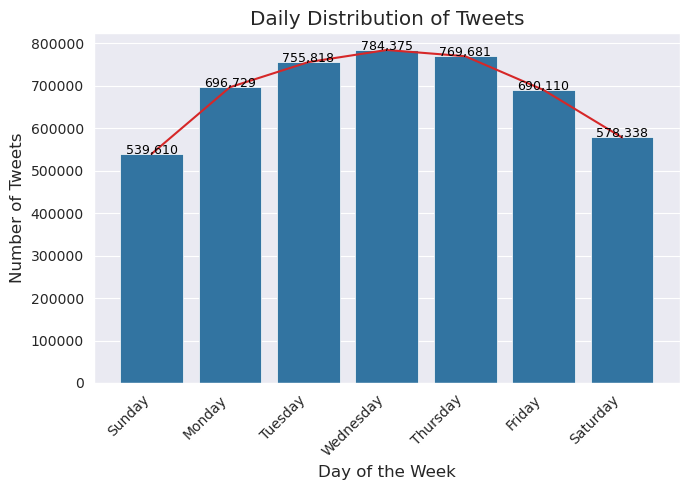

In [125]:
# Distribution of tweets based on day of the week
import matplotlib.pyplot as plt
import seaborn as sns

# set the plot style
sns.set_style('darkgrid')

# convert day column to categorical type
days = ['Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df_day = df_timelines_pd.groupby(by='day').sum()
df_day = df_day.reindex(days)
df_day.reset_index(inplace=True)

# create bar plot
fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=df_day, x='day', y='count_tweets', color='tab:blue', ax=ax)

# add labels and annotations
ax.set_ylabel('Number of Tweets', fontsize = 12)
ax.set_xlabel('Day of the Week', fontsize = 12)
ax.set_title('Daily Distribution of Tweets')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(df_day['count_tweets']):
    ax.text(i, v + 3, str("{:,}".format(v)), ha='center', color='black', fontsize=9)

# plot a line chart showing the trend in tweet counts over time
sns.lineplot(data=df_day, x='day', y='count_tweets', color='tab:red', ax=ax)

plt.tight_layout()
plt.show()


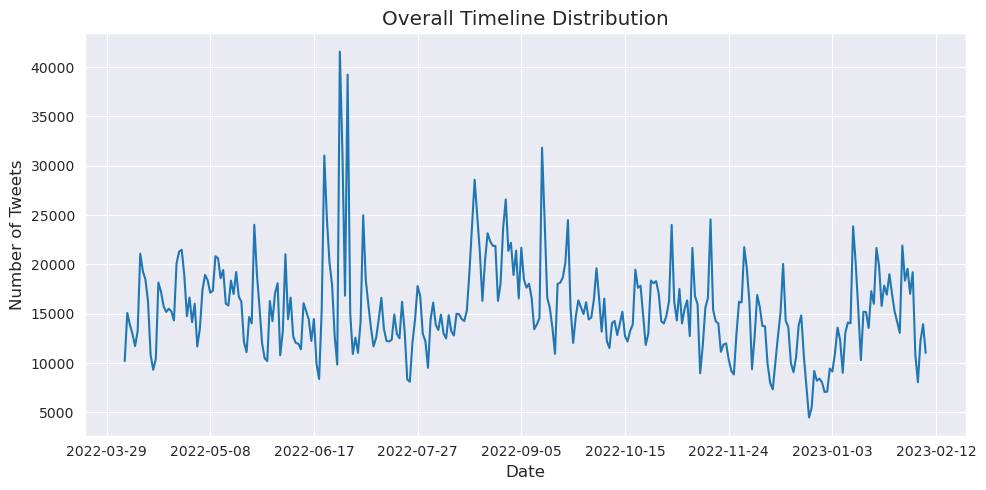

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns

# set the plot style
sns.set_style('darkgrid')

# create line plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df_timelines_pd, x='tweet_created_at', y='count_tweets', color='tab:blue', ax=ax)

# add labels and annotations
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_title('Overall Timeline Distribution')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
plt.show()


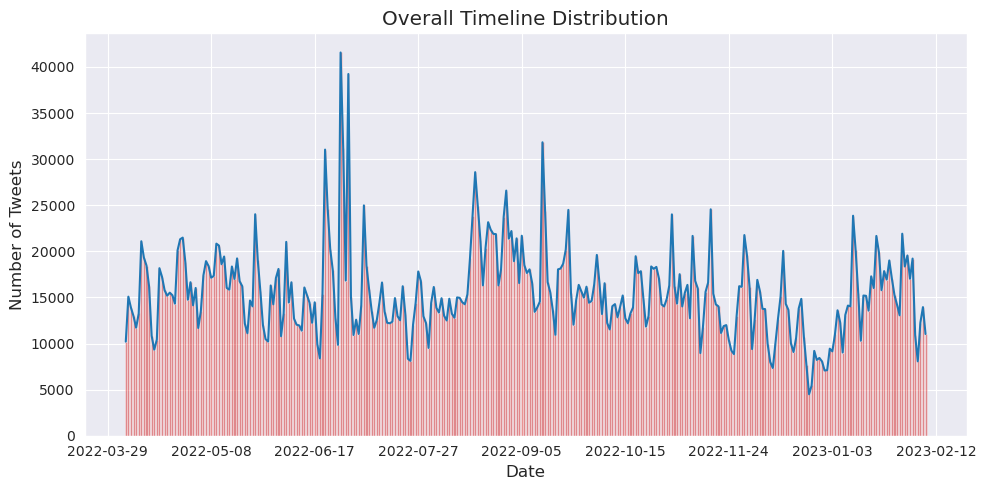

In [135]:
import matplotlib.pyplot as plt
import seaborn as sns

# set the plot style
sns.set_style('darkgrid')

# create line plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data=df_timelines_pd, x='tweet_created_at', y='count_tweets', color='tab:blue', ax=ax)

# create bars for each date
ax.bar(df_timelines_pd['tweet_created_at'], df_timelines_pd['count_tweets'], color='tab:red', alpha=0.5)

# add labels and annotations
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.set_title('Overall Timeline Distribution')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
plt.show()


In [142]:
df.columns

Index(['count_tweets', 'year', 'month', 'day', 'dayNum'], dtype='object')

#### Emergence of ChatGPT in education and its progression in Twitterers

In [6]:
gpt_list = ["ChatGPT", "chatgpt", "Chat GPT", "chat gpt", "CHatGPT", "chagpt", "ChatterGPT", "gpt" ,"GPT", 
            "chatterbotgpt", "GPTChat", "gpt chat", "TalkGPT", "talk to gpt", "AI Chat", "chatbot AI", 
            "Conversational AI", "AI conversationalist", "Digital assistant", "GPT Assistant", "Virtual assistant", 
            "AI friend", "Bot friend", "AI buddy", "Bot buddy"]

gpt_filter = '|'.join(['(' + i + ')' for i in gpt_list])

In [7]:
df_topic = df.filter(df['text'].rlike(gpt_filter)).select(['tweet_created_at','user_name','user_location', 'followers_count','text'])
df_topic = df_topic.withColumn("tweet_created_at", to_date('tweet_created_at'))

In [10]:
df_topic_pd = df_topic.toPandas()

In [12]:
df_topic_pd.head()

,tweet_created_at,user_name,user_location,followers_count,text
0,2023-01-22,Michele Smorgon,Melbourne Australia,39235,queensland public schools to join nsw in banning students from chatgpt https://t.co/gyq1ylm40d https://t.co/pgysefvbvw
1,2023-02-01,Prof. Manish Thakur,India,3696,"rt @richardkimphd: universities can alter the way they structure education and learning, but they should not ban #chatgpt in schools.\n\n#cha…"
2,2023-01-25,VocEdAustralia,Sydney,13546,"@googleaused:as australian colleges crack down on chatgpt, disabled students ... - the japan times https://t.co/nkvk0xbrcb"
3,2023-02-04,Jenny Cruse,None,717,"rt @hadip: schools banning chatgpt? instead of banning technology, here’s an example of how schools can adjust to the reality of generative…"
4,2023-01-23,Altus,"Birmingham, England",36,"rt @noor_siddiqui_: pretty absurd that chatgpt has passed the united states medical licensing examination (usmle). \n\ntoday, it takes 4 year…"


In [44]:
df_topic_pd['tweet_created_at'] = pd.to_datetime(df_topic_pd['tweet_created_at'])
df_topic_pd['month'] = df_topic_pd['tweet_created_at'].dt.to_period('M')
df_topic_pd['Year'] = df_topic_pd['tweet_created_at'].dt.year

In [45]:
df_month_gpt = df_topic_pd.groupby(by='month').count()

In [46]:
df_month_gpt = df_month_gpt.drop(columns = ['user_name','user_location','followers_count','text','Year'], axis =1 )
df_month_gpt = df_month_gpt.rename(columns = {'tweet_created_at':'count_tweets'})
df_month_gpt.reset_index(inplace=True)
df_month_gpt['month'] = df_month_gpt['month'].dt.strftime('%Y-%m')

In [47]:
df_month_gpt

,month,count_tweets
0,2022-04,25
1,2022-05,14
2,2022-06,13
3,2022-07,23
4,2022-08,16
5,2022-09,5
6,2022-10,13
7,2022-11,27
8,2022-12,153
9,2023-01,2404


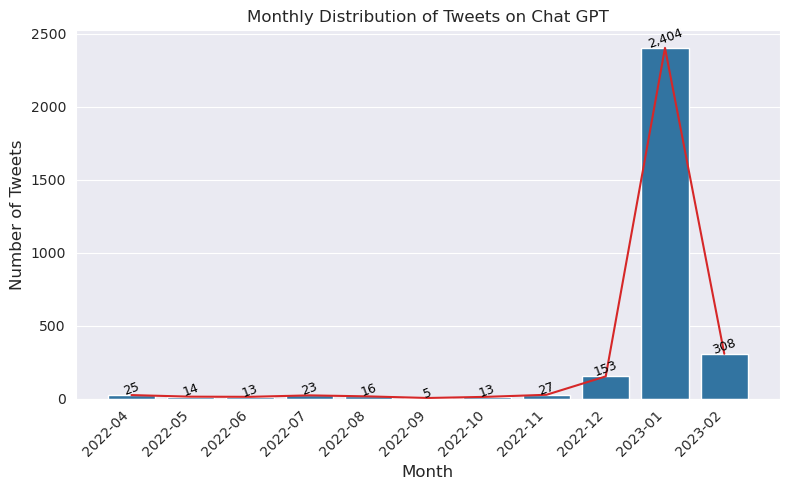

In [49]:
# Monthly distribution of tweets which has content on ChatGPT
import matplotlib.pyplot as plt
import seaborn as sns

# set the plot style
sns.set_style('darkgrid')

# create bar plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=df_month_gpt, x='month', y='count_tweets', color='tab:blue', ax=ax)

# add labels and annotations

ax.set_ylabel('Number of Tweets', fontsize = 12)
ax.set_xlabel('Month', fontsize = 12)
ax.set_title('Monthly Distribution of Tweets on Chat GPT')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for i, v in enumerate(df_month_gpt['count_tweets']):
    ax.text(i, v + 3, str("{:,}".format(v)), ha='center', color='black', fontsize=9, rotation=20)

# plot a line chart showing the trend in tweet counts over time
sns.lineplot(data=df_month_gpt, x='month', y='count_tweets', color='tab:red', ax=ax)

plt.tight_layout()
plt.show()
